# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.

## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import torch

from tqdm import tqdm

from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset
from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
!pip install segmentation-models-pytorch
!pip install pytorch-lightning

import pytorch_lightning as pl
import segmentation_models_pytorch as smp

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.3 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=b385fdc0f395c20a900f79333a2c84b86ba54baf470f1e4c96e49d88b2d110f2
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=35204d851a615e4042d3a267774bbe3c0f14e9654f24a88c90a42c0ccab7515a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientne

## Choose parameters

In [3]:
# Define training params
epochs = 1000
batch_size = 128
lr = 1e-3


#Choose loss weight
weight_dice = 1
weight_focal = 1


#Choose net from: unet, unetplusplus, manet, linknet, fpn, pspnet, pan, deeplabv3, deeplabv3+ 
net_name = 'pspnet'

#Choose net parameters
encoder_name='se_resnext101_32x4d' 
encoder_depth=3
encoder_weights=None  
decoder_use_batchnorm=False
decoder_channels=(128, 64, 32)

## ⏳ Load the Data

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load the data
data = np.load("/kaggle/input/an2dl-hw22024-2025/flippedx4_no_aliens.npz")
training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

# Check shapes of the data
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

# Split the training data into training and validation sets (e.g., 80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Now you have your validation data: X_val_split, y_val_split
print(f"Validation X shape: {X_val.shape}")
print(f"Validation y shape: {y_val.shape}")


Training X shape: (10020, 64, 128)
Training y shape: (10020, 64, 128)
Test X shape: (10022, 64, 128)
Validation X shape: (2004, 64, 128)
Validation y shape: (2004, 64, 128)


## Preprocessing and data info

In [5]:

X_train_tensor = torch.tensor(X_train / 255.0).unsqueeze(1).float()  
y_train_tensor = torch.tensor(y_train).long()

X_val_tensor = torch.tensor(X_val / 255.0).unsqueeze(1).float()
y_val_tensor = torch.tensor(y_val).long()

X_test_tensor = torch.tensor(X_test / 255.0).unsqueeze(1).float()

# Create TensorDataset for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

## 🛠️ Create Model

In [6]:
class MyModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # Create the model
        self.model = smp.create_model(
            net_name,
            encoder_name=encoder_name,
            encoder_depth=encoder_depth,
            encoder_weights=encoder_weights,
            psp_use_batchnorm = True,
            psp_dropout = 0.3,
            in_channels=1,
            classes=5,
            activation='softmax'
        )

        self.number_of_classes = 5

        # Step metrics tracking
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

        # Define Loss function
        self.dice_loss = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=False, classes=[1, 2, 3, 4], ignore_index = 0)
        self.focal_loss = smp.losses.FocalLoss(smp.losses.MULTICLASS_MODE, ignore_index = 0)

    # Compute combined loss
    def loss_fn(self, logits, target):
        # Calcolo della Dice Loss
        dice = self.dice_loss(logits, target)
        # Calcolo della Focal Loss
        focal = self.focal_loss(logits, target)
        # Somma pesata
        return weight_dice * dice + weight_focal * focal

    
    
    def forward(self, image):
        mask = self.model(image)
        return mask


    # compute loss and stats
    def shared_step(self, batch, stage):

        image, mask = batch
    

        assert image.ndim == 4  # [batch_size, channels, H, W]
    

        mask = mask.long()
    

        assert mask.ndim == 3  # [batch_size, H, W]
    

        prob_mask = self.forward(image)  # Il modello restituisce probabilità grazie a `softmax`
    

        assert (
            prob_mask.shape[1] == self.number_of_classes
        ), f"Expected {self.model.classes} channels, got {prob_mask.shape[1]}"
    

        pred_mask = prob_mask.argmax(dim=1)  
    

        loss = self.loss_fn(prob_mask, mask)
    

        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask, mask, mode="multiclass", num_classes=self.number_of_classes)

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    
    def shared_epoch_end(self, outputs, stage):

        tp = torch.cat([x["tp"] for x in outputs], dim=0)  # Shape: [batch_size, num_classes]
        fp = torch.cat([x["fp"] for x in outputs], dim=0)
        fn = torch.cat([x["fn"] for x in outputs], dim=0)
        tn = torch.cat([x["tn"] for x in outputs], dim=0)
    

        labels_to_exclude = [0]  # Classe 0 = background 
        num_classes = tp.shape[1]
    
        # Compute IoU 
        iou_per_class = []
        for c in range(num_classes):
            if c in labels_to_exclude:
                iou_per_class.append(float('nan'))  
            else:

                tp_c = tp[:, c].sum()
                fp_c = fp[:, c].sum()
                fn_c = fn[:, c].sum()


                union = tp_c + fp_c + fn_c
                iou_per_class.append(tp_c.item() / union.item() if union > 0 else float('nan'))
    

        mean_iou = torch.tensor(iou_per_class).nanmean().item()
    

        mean_loss = torch.stack([x["loss"] for x in outputs]).mean()


        metrics = {
            f"{stage}_mean_iou": mean_iou,  
            f"{stage}_loss": mean_loss,
        }
        for c, iou in enumerate(iou_per_class):
            metrics[f"{stage}_iou_class_{c}"] = iou


        print(f"\nEpoch {self.current_epoch} - Metrics for {stage}:")
        for key, value in metrics.items():
            print(f"  {key}: {value:.4f}" if not isinstance(value, float) or not torch.isnan(torch.tensor(value)) else f"  {key}: NaN")
    

        self.log_dict(metrics, prog_bar=True)


    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    
    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()

    
    def validation_step(self, batch, batch_idx):
        val_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(val_loss_info)
        return val_loss_info

    
    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()


    def configure_optimizers(self):
        # Definizione dell'ottimizzatore
        optimizer = torch.optim.NAdam(self.parameters(), lr=lr, weight_decay=1e-5)
    
        # Scheduler ReduceLROnPlateau
        scheduler = ReduceLROnPlateau(
            optimizer,
       
            mode="min",       
            factor=0.4,        
            patience=15,        
            verbose=True,      
        )
    

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "valid_loss",  
            },
        }

In [7]:
model = MyModel()

## Training

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Callback for EarlyStopping
early_stop_callback = EarlyStopping(
    monitor="valid_loss",
    mode="min",
    patience=20,
    verbose=True
)

# Callback for saving the best model
checkpoint_callback = ModelCheckpoint(
    monitor="valid_mean_iou",      
    mode="max",                
    save_top_k=1,              
    filename="best_model",     
    verbose=True
)


trainer = pl.Trainer(max_epochs=epochs, 
                     log_every_n_steps=1,
                     callbacks=[checkpoint_callback, early_stop_callback])


trainer.fit(model,
            train_dataloaders=train_loader,
            val_dataloaders=valid_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)



Epoch 0 - Metrics for valid:
  valid_mean_iou: 0.0108
  valid_loss: 1.8997
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.0431
  valid_iou_class_2: 0.0001
  valid_iou_class_3: 0.0000
  valid_iou_class_4: 0.0000


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 0 - Metrics for valid:
  valid_mean_iou: 0.1472
  valid_loss: 1.8355
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.0000
  valid_iou_class_2: 0.3309
  valid_iou_class_3: 0.2579
  valid_iou_class_4: 0.0000

Epoch 0 - Metrics for train:
  train_mean_iou: 0.3192
  train_loss: 1.3867
  train_iou_class_0: NaN
  train_iou_class_1: 0.4625
  train_iou_class_2: 0.3624
  train_iou_class_3: 0.4267
  train_iou_class_4: 0.0252


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 1 - Metrics for valid:
  valid_mean_iou: 0.1000
  valid_loss: 1.8965
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.3487
  valid_iou_class_2: 0.0022
  valid_iou_class_3: 0.0493
  valid_iou_class_4: 0.0000

Epoch 1 - Metrics for train:
  train_mean_iou: 0.3769
  train_loss: 1.2808
  train_iou_class_0: NaN
  train_iou_class_1: 0.5558
  train_iou_class_2: 0.4444
  train_iou_class_3: 0.5074
  train_iou_class_4: 0.0000


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 2 - Metrics for valid:
  valid_mean_iou: 0.2243
  valid_loss: 1.6265
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.2669
  valid_iou_class_2: 0.3241
  valid_iou_class_3: 0.3062
  valid_iou_class_4: 0.0000

Epoch 2 - Metrics for train:
  train_mean_iou: 0.3859
  train_loss: 1.2518
  train_iou_class_0: NaN
  train_iou_class_1: 0.5822
  train_iou_class_2: 0.4621
  train_iou_class_3: 0.4993
  train_iou_class_4: 0.0000


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 3 - Metrics for valid:
  valid_mean_iou: 0.3014
  valid_loss: 1.4195
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.4830
  valid_iou_class_2: 0.3031
  valid_iou_class_3: 0.4196
  valid_iou_class_4: 0.0000

Epoch 3 - Metrics for train:
  train_mean_iou: 0.3953
  train_loss: 1.2373
  train_iou_class_0: NaN
  train_iou_class_1: 0.5955
  train_iou_class_2: 0.4788
  train_iou_class_3: 0.5070
  train_iou_class_4: 0.0000


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 4 - Metrics for valid:
  valid_mean_iou: 0.2269
  valid_loss: 1.6191
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.3016
  valid_iou_class_2: 0.3079
  valid_iou_class_3: 0.2787
  valid_iou_class_4: 0.0194

Epoch 4 - Metrics for train:
  train_mean_iou: 0.4229
  train_loss: 1.1916
  train_iou_class_0: NaN
  train_iou_class_1: 0.6276
  train_iou_class_2: 0.4926
  train_iou_class_3: 0.5414
  train_iou_class_4: 0.0302


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 5 - Metrics for valid:
  valid_mean_iou: 0.1776
  valid_loss: 1.6907
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.3921
  valid_iou_class_2: 0.1841
  valid_iou_class_3: 0.0984
  valid_iou_class_4: 0.0357

Epoch 5 - Metrics for train:
  train_mean_iou: 0.4245
  train_loss: 1.1812
  train_iou_class_0: NaN
  train_iou_class_1: 0.6245
  train_iou_class_2: 0.4975
  train_iou_class_3: 0.5509
  train_iou_class_4: 0.0253


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 6 - Metrics for valid:
  valid_mean_iou: 0.3722
  valid_loss: 1.2364
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5658
  valid_iou_class_2: 0.4996
  valid_iou_class_3: 0.3488
  valid_iou_class_4: 0.0746

Epoch 6 - Metrics for train:
  train_mean_iou: 0.4245
  train_loss: 1.1645
  train_iou_class_0: NaN
  train_iou_class_1: 0.6264
  train_iou_class_2: 0.4991
  train_iou_class_3: 0.5456
  train_iou_class_4: 0.0269


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 7 - Metrics for valid:
  valid_mean_iou: 0.1453
  valid_loss: 1.7769
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.3753
  valid_iou_class_2: 0.1179
  valid_iou_class_3: 0.0720
  valid_iou_class_4: 0.0161

Epoch 7 - Metrics for train:
  train_mean_iou: 0.4301
  train_loss: 1.1419
  train_iou_class_0: NaN
  train_iou_class_1: 0.6319
  train_iou_class_2: 0.5112
  train_iou_class_3: 0.5475
  train_iou_class_4: 0.0296


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 8 - Metrics for valid:
  valid_mean_iou: 0.3429
  valid_loss: 1.3048
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.4321
  valid_iou_class_2: 0.4238
  valid_iou_class_3: 0.4717
  valid_iou_class_4: 0.0441

Epoch 8 - Metrics for train:
  train_mean_iou: 0.4428
  train_loss: 1.1393
  train_iou_class_0: NaN
  train_iou_class_1: 0.6403
  train_iou_class_2: 0.5059
  train_iou_class_3: 0.5544
  train_iou_class_4: 0.0705


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 9 - Metrics for valid:
  valid_mean_iou: 0.2941
  valid_loss: 1.4519
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.4184
  valid_iou_class_2: 0.3953
  valid_iou_class_3: 0.3047
  valid_iou_class_4: 0.0581

Epoch 9 - Metrics for train:
  train_mean_iou: 0.4533
  train_loss: 1.1173
  train_iou_class_0: NaN
  train_iou_class_1: 0.6572
  train_iou_class_2: 0.5266
  train_iou_class_3: 0.5551
  train_iou_class_4: 0.0743


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 10 - Metrics for valid:
  valid_mean_iou: 0.2768
  valid_loss: 1.5418
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.2502
  valid_iou_class_2: 0.3023
  valid_iou_class_3: 0.4824
  valid_iou_class_4: 0.0724

Epoch 10 - Metrics for train:
  train_mean_iou: 0.4464
  train_loss: 1.1054
  train_iou_class_0: NaN
  train_iou_class_1: 0.6517
  train_iou_class_2: 0.5308
  train_iou_class_3: 0.5637
  train_iou_class_4: 0.0391


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 11 - Metrics for valid:
  valid_mean_iou: 0.3554
  valid_loss: 1.3041
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.4853
  valid_iou_class_2: 0.4503
  valid_iou_class_3: 0.4559
  valid_iou_class_4: 0.0300

Epoch 11 - Metrics for train:
  train_mean_iou: 0.4225
  train_loss: 1.1681
  train_iou_class_0: NaN
  train_iou_class_1: 0.6123
  train_iou_class_2: 0.4960
  train_iou_class_3: 0.5485
  train_iou_class_4: 0.0333


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 12 - Metrics for valid:
  valid_mean_iou: 0.4262
  valid_loss: 1.1552
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6062
  valid_iou_class_2: 0.5463
  valid_iou_class_3: 0.5206
  valid_iou_class_4: 0.0318

Epoch 12 - Metrics for train:
  train_mean_iou: 0.4484
  train_loss: 1.1081
  train_iou_class_0: NaN
  train_iou_class_1: 0.6527
  train_iou_class_2: 0.5303
  train_iou_class_3: 0.5702
  train_iou_class_4: 0.0406


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 13 - Metrics for valid:
  valid_mean_iou: 0.1076
  valid_loss: 1.8696
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.3541
  valid_iou_class_2: 0.0460
  valid_iou_class_3: 0.0181
  valid_iou_class_4: 0.0124

Epoch 13 - Metrics for train:
  train_mean_iou: 0.4624
  train_loss: 1.0728
  train_iou_class_0: NaN
  train_iou_class_1: 0.6795
  train_iou_class_2: 0.5472
  train_iou_class_3: 0.5788
  train_iou_class_4: 0.0440


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 14 - Metrics for valid:
  valid_mean_iou: 0.2990
  valid_loss: 1.4514
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.3527
  valid_iou_class_2: 0.4059
  valid_iou_class_3: 0.3511
  valid_iou_class_4: 0.0862

Epoch 14 - Metrics for train:
  train_mean_iou: 0.4650
  train_loss: 1.0691
  train_iou_class_0: NaN
  train_iou_class_1: 0.6846
  train_iou_class_2: 0.5494
  train_iou_class_3: 0.5756
  train_iou_class_4: 0.0506


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 15 - Metrics for valid:
  valid_mean_iou: 0.2465
  valid_loss: 1.5274
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.4257
  valid_iou_class_2: 0.2868
  valid_iou_class_3: 0.1817
  valid_iou_class_4: 0.0919

Epoch 15 - Metrics for train:
  train_mean_iou: 0.4521
  train_loss: 1.1005
  train_iou_class_0: NaN
  train_iou_class_1: 0.6536
  train_iou_class_2: 0.5296
  train_iou_class_3: 0.5548
  train_iou_class_4: 0.0702


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 16 - Metrics for valid:
  valid_mean_iou: 0.3974
  valid_loss: 1.2733
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5170
  valid_iou_class_2: 0.4375
  valid_iou_class_3: 0.4897
  valid_iou_class_4: 0.1453

Epoch 16 - Metrics for train:
  train_mean_iou: 0.4475
  train_loss: 1.1120
  train_iou_class_0: NaN
  train_iou_class_1: 0.6502
  train_iou_class_2: 0.5292
  train_iou_class_3: 0.5678
  train_iou_class_4: 0.0429


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 17 - Metrics for valid:
  valid_mean_iou: 0.4638
  valid_loss: 1.1168
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6770
  valid_iou_class_2: 0.5309
  valid_iou_class_3: 0.5549
  valid_iou_class_4: 0.0923

Epoch 17 - Metrics for train:
  train_mean_iou: 0.4618
  train_loss: 1.0937
  train_iou_class_0: NaN
  train_iou_class_1: 0.6728
  train_iou_class_2: 0.5379
  train_iou_class_3: 0.5881
  train_iou_class_4: 0.0483


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 18 - Metrics for valid:
  valid_mean_iou: 0.3847
  valid_loss: 1.2216
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5279
  valid_iou_class_2: 0.4511
  valid_iou_class_3: 0.4833
  valid_iou_class_4: 0.0767

Epoch 18 - Metrics for train:
  train_mean_iou: 0.4686
  train_loss: 1.0766
  train_iou_class_0: NaN
  train_iou_class_1: 0.6701
  train_iou_class_2: 0.5360
  train_iou_class_3: 0.5874
  train_iou_class_4: 0.0808


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 19 - Metrics for valid:
  valid_mean_iou: 0.4100
  valid_loss: 1.1807
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6207
  valid_iou_class_2: 0.4837
  valid_iou_class_3: 0.4336
  valid_iou_class_4: 0.1021

Epoch 19 - Metrics for train:
  train_mean_iou: 0.4821
  train_loss: 1.0605
  train_iou_class_0: NaN
  train_iou_class_1: 0.6824
  train_iou_class_2: 0.5490
  train_iou_class_3: 0.5823
  train_iou_class_4: 0.1147


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 20 - Metrics for valid:
  valid_mean_iou: 0.1273
  valid_loss: 1.7913
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.3653
  valid_iou_class_2: 0.1359
  valid_iou_class_3: 0.0048
  valid_iou_class_4: 0.0031

Epoch 20 - Metrics for train:
  train_mean_iou: 0.4916
  train_loss: 1.0316
  train_iou_class_0: NaN
  train_iou_class_1: 0.7009
  train_iou_class_2: 0.5633
  train_iou_class_3: 0.5986
  train_iou_class_4: 0.1035


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 21 - Metrics for valid:
  valid_mean_iou: 0.4398
  valid_loss: 1.1564
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6405
  valid_iou_class_2: 0.4984
  valid_iou_class_3: 0.4780
  valid_iou_class_4: 0.1421

Epoch 21 - Metrics for train:
  train_mean_iou: 0.4662
  train_loss: 1.0823
  train_iou_class_0: NaN
  train_iou_class_1: 0.6720
  train_iou_class_2: 0.5503
  train_iou_class_3: 0.5576
  train_iou_class_4: 0.0850


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 22 - Metrics for valid:
  valid_mean_iou: 0.4474
  valid_loss: 1.1351
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6095
  valid_iou_class_2: 0.5172
  valid_iou_class_3: 0.5096
  valid_iou_class_4: 0.1533

Epoch 22 - Metrics for train:
  train_mean_iou: 0.4944
  train_loss: 1.0384
  train_iou_class_0: NaN
  train_iou_class_1: 0.7002
  train_iou_class_2: 0.5572
  train_iou_class_3: 0.6063
  train_iou_class_4: 0.1137


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 23 - Metrics for valid:
  valid_mean_iou: 0.1823
  valid_loss: 1.7281
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.1540
  valid_iou_class_2: 0.2672
  valid_iou_class_3: 0.2647
  valid_iou_class_4: 0.0432

Epoch 23 - Metrics for train:
  train_mean_iou: 0.4947
  train_loss: 1.0345
  train_iou_class_0: NaN
  train_iou_class_1: 0.7041
  train_iou_class_2: 0.5620
  train_iou_class_3: 0.6121
  train_iou_class_4: 0.1006


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 24 - Metrics for valid:
  valid_mean_iou: 0.4120
  valid_loss: 1.2063
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5839
  valid_iou_class_2: 0.4895
  valid_iou_class_3: 0.4166
  valid_iou_class_4: 0.1579

Epoch 24 - Metrics for train:
  train_mean_iou: 0.4895
  train_loss: 1.0351
  train_iou_class_0: NaN
  train_iou_class_1: 0.6956
  train_iou_class_2: 0.5576
  train_iou_class_3: 0.6093
  train_iou_class_4: 0.0956


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 25 - Metrics for valid:
  valid_mean_iou: 0.3888
  valid_loss: 1.2416
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5532
  valid_iou_class_2: 0.4894
  valid_iou_class_3: 0.4186
  valid_iou_class_4: 0.0939

Epoch 25 - Metrics for train:
  train_mean_iou: 0.4734
  train_loss: 1.0641
  train_iou_class_0: NaN
  train_iou_class_1: 0.6727
  train_iou_class_2: 0.5471
  train_iou_class_3: 0.5857
  train_iou_class_4: 0.0879


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 26 - Metrics for valid:
  valid_mean_iou: 0.4150
  valid_loss: 1.1754
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5798
  valid_iou_class_2: 0.4697
  valid_iou_class_3: 0.5272
  valid_iou_class_4: 0.0834

Epoch 26 - Metrics for train:
  train_mean_iou: 0.4489
  train_loss: 1.0986
  train_iou_class_0: NaN
  train_iou_class_1: 0.6612
  train_iou_class_2: 0.5511
  train_iou_class_3: 0.5281
  train_iou_class_4: 0.0553


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 27 - Metrics for valid:
  valid_mean_iou: 0.3924
  valid_loss: 1.2378
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5499
  valid_iou_class_2: 0.4632
  valid_iou_class_3: 0.4691
  valid_iou_class_4: 0.0872

Epoch 27 - Metrics for train:
  train_mean_iou: 0.4858
  train_loss: 1.0392
  train_iou_class_0: NaN
  train_iou_class_1: 0.6862
  train_iou_class_2: 0.5508
  train_iou_class_3: 0.6014
  train_iou_class_4: 0.1047


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 28 - Metrics for valid:
  valid_mean_iou: 0.4614
  valid_loss: 1.1176
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6180
  valid_iou_class_2: 0.5328
  valid_iou_class_3: 0.5285
  valid_iou_class_4: 0.1663

Epoch 28 - Metrics for train:
  train_mean_iou: 0.4976
  train_loss: 1.0265
  train_iou_class_0: NaN
  train_iou_class_1: 0.6908
  train_iou_class_2: 0.5582
  train_iou_class_3: 0.6104
  train_iou_class_4: 0.1310


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 29 - Metrics for valid:
  valid_mean_iou: 0.3543
  valid_loss: 1.3691
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5067
  valid_iou_class_2: 0.5342
  valid_iou_class_3: 0.1825
  valid_iou_class_4: 0.1936

Epoch 29 - Metrics for train:
  train_mean_iou: 0.5027
  train_loss: 1.0129
  train_iou_class_0: NaN
  train_iou_class_1: 0.7091
  train_iou_class_2: 0.5688
  train_iou_class_3: 0.6169
  train_iou_class_4: 0.1159


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 30 - Metrics for valid:
  valid_mean_iou: 0.3237
  valid_loss: 1.3940
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5060
  valid_iou_class_2: 0.4855
  valid_iou_class_3: 0.1275
  valid_iou_class_4: 0.1759

Epoch 30 - Metrics for train:
  train_mean_iou: 0.5030
  train_loss: 0.9952
  train_iou_class_0: NaN
  train_iou_class_1: 0.7067
  train_iou_class_2: 0.5735
  train_iou_class_3: 0.6106
  train_iou_class_4: 0.1213


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 31 - Metrics for valid:
  valid_mean_iou: 0.4451
  valid_loss: 1.0838
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6543
  valid_iou_class_2: 0.4979
  valid_iou_class_3: 0.5453
  valid_iou_class_4: 0.0831

Epoch 31 - Metrics for train:
  train_mean_iou: 0.5163
  train_loss: 0.9973
  train_iou_class_0: NaN
  train_iou_class_1: 0.7177
  train_iou_class_2: 0.5851
  train_iou_class_3: 0.6194
  train_iou_class_4: 0.1429


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 32 - Metrics for valid:
  valid_mean_iou: 0.4948
  valid_loss: 1.0634
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6996
  valid_iou_class_2: 0.5266
  valid_iou_class_3: 0.6163
  valid_iou_class_4: 0.1368

Epoch 32 - Metrics for train:
  train_mean_iou: 0.5059
  train_loss: 1.0081
  train_iou_class_0: NaN
  train_iou_class_1: 0.7053
  train_iou_class_2: 0.5711
  train_iou_class_3: 0.6125
  train_iou_class_4: 0.1348


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 33 - Metrics for valid:
  valid_mean_iou: 0.1546
  valid_loss: 1.7702
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.3690
  valid_iou_class_2: 0.1149
  valid_iou_class_3: 0.0508
  valid_iou_class_4: 0.0838

Epoch 33 - Metrics for train:
  train_mean_iou: 0.4963
  train_loss: 1.0226
  train_iou_class_0: NaN
  train_iou_class_1: 0.7101
  train_iou_class_2: 0.5771
  train_iou_class_3: 0.6128
  train_iou_class_4: 0.0854


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 34 - Metrics for valid:
  valid_mean_iou: 0.4826
  valid_loss: 1.0595
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6821
  valid_iou_class_2: 0.4945
  valid_iou_class_3: 0.6274
  valid_iou_class_4: 0.1264

Epoch 34 - Metrics for train:
  train_mean_iou: 0.4942
  train_loss: 1.0112
  train_iou_class_0: NaN
  train_iou_class_1: 0.7092
  train_iou_class_2: 0.5690
  train_iou_class_3: 0.6226
  train_iou_class_4: 0.0762


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 35 - Metrics for valid:
  valid_mean_iou: 0.3829
  valid_loss: 1.2480
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5439
  valid_iou_class_2: 0.4543
  valid_iou_class_3: 0.4140
  valid_iou_class_4: 0.1193

Epoch 35 - Metrics for train:
  train_mean_iou: 0.5280
  train_loss: 0.9899
  train_iou_class_0: NaN
  train_iou_class_1: 0.7303
  train_iou_class_2: 0.5806
  train_iou_class_3: 0.6500
  train_iou_class_4: 0.1510


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 36 - Metrics for valid:
  valid_mean_iou: 0.3588
  valid_loss: 1.3313
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5216
  valid_iou_class_2: 0.4802
  valid_iou_class_3: 0.2714
  valid_iou_class_4: 0.1620

Epoch 36 - Metrics for train:
  train_mean_iou: 0.5234
  train_loss: 0.9748
  train_iou_class_0: NaN
  train_iou_class_1: 0.7335
  train_iou_class_2: 0.5942
  train_iou_class_3: 0.6369
  train_iou_class_4: 0.1290


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 37 - Metrics for valid:
  valid_mean_iou: 0.4249
  valid_loss: 1.1798
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5788
  valid_iou_class_2: 0.4574
  valid_iou_class_3: 0.5622
  valid_iou_class_4: 0.1014

Epoch 37 - Metrics for train:
  train_mean_iou: 0.5178
  train_loss: 0.9844
  train_iou_class_0: NaN
  train_iou_class_1: 0.7240
  train_iou_class_2: 0.5921
  train_iou_class_3: 0.6316
  train_iou_class_4: 0.1235


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 38 - Metrics for valid:
  valid_mean_iou: 0.4199
  valid_loss: 1.1990
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5754
  valid_iou_class_2: 0.4867
  valid_iou_class_3: 0.4590
  valid_iou_class_4: 0.1586

Epoch 38 - Metrics for train:
  train_mean_iou: 0.5100
  train_loss: 0.9800
  train_iou_class_0: NaN
  train_iou_class_1: 0.7256
  train_iou_class_2: 0.5949
  train_iou_class_3: 0.6255
  train_iou_class_4: 0.0939


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 39 - Metrics for valid:
  valid_mean_iou: 0.4971
  valid_loss: 1.0389
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7074
  valid_iou_class_2: 0.5620
  valid_iou_class_3: 0.5816
  valid_iou_class_4: 0.1376

Epoch 39 - Metrics for train:
  train_mean_iou: 0.5271
  train_loss: 1.0003
  train_iou_class_0: NaN
  train_iou_class_1: 0.7293
  train_iou_class_2: 0.5874
  train_iou_class_3: 0.6413
  train_iou_class_4: 0.1504


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 40 - Metrics for valid:
  valid_mean_iou: 0.4470
  valid_loss: 1.0960
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6503
  valid_iou_class_2: 0.5530
  valid_iou_class_3: 0.5307
  valid_iou_class_4: 0.0541

Epoch 40 - Metrics for train:
  train_mean_iou: 0.5216
  train_loss: 0.9625
  train_iou_class_0: NaN
  train_iou_class_1: 0.7271
  train_iou_class_2: 0.5935
  train_iou_class_3: 0.6428
  train_iou_class_4: 0.1230


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 41 - Metrics for valid:
  valid_mean_iou: 0.4362
  valid_loss: 1.1730
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5568
  valid_iou_class_2: 0.5019
  valid_iou_class_3: 0.5243
  valid_iou_class_4: 0.1618

Epoch 41 - Metrics for train:
  train_mean_iou: 0.5349
  train_loss: 0.9507
  train_iou_class_0: NaN
  train_iou_class_1: 0.7396
  train_iou_class_2: 0.6023
  train_iou_class_3: 0.6647
  train_iou_class_4: 0.1329


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 42 - Metrics for valid:
  valid_mean_iou: 0.4056
  valid_loss: 1.2225
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5475
  valid_iou_class_2: 0.4338
  valid_iou_class_3: 0.5264
  valid_iou_class_4: 0.1146

Epoch 42 - Metrics for train:
  train_mean_iou: 0.5140
  train_loss: 0.9806
  train_iou_class_0: NaN
  train_iou_class_1: 0.7170
  train_iou_class_2: 0.6047
  train_iou_class_3: 0.6383
  train_iou_class_4: 0.0959


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 43 - Metrics for valid:
  valid_mean_iou: 0.2025
  valid_loss: 1.6702
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.1754
  valid_iou_class_2: 0.3178
  valid_iou_class_3: 0.2647
  valid_iou_class_4: 0.0522

Epoch 43 - Metrics for train:
  train_mean_iou: 0.5180
  train_loss: 0.9804
  train_iou_class_0: NaN
  train_iou_class_1: 0.7187
  train_iou_class_2: 0.5997
  train_iou_class_3: 0.6286
  train_iou_class_4: 0.1250


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 44 - Metrics for valid:
  valid_mean_iou: 0.3976
  valid_loss: 1.2296
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5854
  valid_iou_class_2: 0.5325
  valid_iou_class_3: 0.4216
  valid_iou_class_4: 0.0508

Epoch 44 - Metrics for train:
  train_mean_iou: 0.5184
  train_loss: 0.9701
  train_iou_class_0: NaN
  train_iou_class_1: 0.7333
  train_iou_class_2: 0.5947
  train_iou_class_3: 0.6505
  train_iou_class_4: 0.0953


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 45 - Metrics for valid:
  valid_mean_iou: 0.4598
  valid_loss: 1.0575
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6413
  valid_iou_class_2: 0.5355
  valid_iou_class_3: 0.5296
  valid_iou_class_4: 0.1328

Epoch 45 - Metrics for train:
  train_mean_iou: 0.5308
  train_loss: 0.9446
  train_iou_class_0: NaN
  train_iou_class_1: 0.7348
  train_iou_class_2: 0.6047
  train_iou_class_3: 0.6468
  train_iou_class_4: 0.1367


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 46 - Metrics for valid:
  valid_mean_iou: 0.4109
  valid_loss: 1.2281
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5184
  valid_iou_class_2: 0.5024
  valid_iou_class_3: 0.4919
  valid_iou_class_4: 0.1308

Epoch 46 - Metrics for train:
  train_mean_iou: 0.5568
  train_loss: 0.9345
  train_iou_class_0: NaN
  train_iou_class_1: 0.7433
  train_iou_class_2: 0.6064
  train_iou_class_3: 0.6699
  train_iou_class_4: 0.2075


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 47 - Metrics for valid:
  valid_mean_iou: 0.3388
  valid_loss: 1.3111
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.4641
  valid_iou_class_2: 0.4291
  valid_iou_class_3: 0.3469
  valid_iou_class_4: 0.1153

Epoch 47 - Metrics for train:
  train_mean_iou: 0.5376
  train_loss: 0.9481
  train_iou_class_0: NaN
  train_iou_class_1: 0.7429
  train_iou_class_2: 0.6170
  train_iou_class_3: 0.6592
  train_iou_class_4: 0.1312


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 48 - Metrics for valid:
  valid_mean_iou: 0.3379
  valid_loss: 1.3710
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.4800
  valid_iou_class_2: 0.4278
  valid_iou_class_3: 0.3397
  valid_iou_class_4: 0.1042

Epoch 48 - Metrics for train:
  train_mean_iou: 0.5350
  train_loss: 0.9418
  train_iou_class_0: NaN
  train_iou_class_1: 0.7395
  train_iou_class_2: 0.6192
  train_iou_class_3: 0.6490
  train_iou_class_4: 0.1326


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 49 - Metrics for valid:
  valid_mean_iou: 0.4950
  valid_loss: 1.0280
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6998
  valid_iou_class_2: 0.5761
  valid_iou_class_3: 0.5666
  valid_iou_class_4: 0.1375

Epoch 49 - Metrics for train:
  train_mean_iou: 0.5466
  train_loss: 0.9254
  train_iou_class_0: NaN
  train_iou_class_1: 0.7472
  train_iou_class_2: 0.6201
  train_iou_class_3: 0.6657
  train_iou_class_4: 0.1535


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 50 - Metrics for valid:
  valid_mean_iou: 0.4744
  valid_loss: 1.0472
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6944
  valid_iou_class_2: 0.5737
  valid_iou_class_3: 0.5437
  valid_iou_class_4: 0.0857

Epoch 50 - Metrics for train:
  train_mean_iou: 0.5461
  train_loss: 0.9340
  train_iou_class_0: NaN
  train_iou_class_1: 0.7471
  train_iou_class_2: 0.6234
  train_iou_class_3: 0.6647
  train_iou_class_4: 0.1493


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 51 - Metrics for valid:
  valid_mean_iou: 0.4957
  valid_loss: 1.0535
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7054
  valid_iou_class_2: 0.5441
  valid_iou_class_3: 0.6103
  valid_iou_class_4: 0.1231

Epoch 51 - Metrics for train:
  train_mean_iou: 0.5395
  train_loss: 0.9436
  train_iou_class_0: NaN
  train_iou_class_1: 0.7369
  train_iou_class_2: 0.6081
  train_iou_class_3: 0.6675
  train_iou_class_4: 0.1456


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 52 - Metrics for valid:
  valid_mean_iou: 0.5033
  valid_loss: 1.0013
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7159
  valid_iou_class_2: 0.5816
  valid_iou_class_3: 0.6060
  valid_iou_class_4: 0.1097

Epoch 52 - Metrics for train:
  train_mean_iou: 0.5531
  train_loss: 0.9293
  train_iou_class_0: NaN
  train_iou_class_1: 0.7448
  train_iou_class_2: 0.6159
  train_iou_class_3: 0.6712
  train_iou_class_4: 0.1805


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 53 - Metrics for valid:
  valid_mean_iou: 0.4141
  valid_loss: 1.2092
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5728
  valid_iou_class_2: 0.5206
  valid_iou_class_3: 0.4678
  valid_iou_class_4: 0.0951

Epoch 53 - Metrics for train:
  train_mean_iou: 0.5539
  train_loss: 0.9136
  train_iou_class_0: NaN
  train_iou_class_1: 0.7532
  train_iou_class_2: 0.6258
  train_iou_class_3: 0.6716
  train_iou_class_4: 0.1652


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 54 - Metrics for valid:
  valid_mean_iou: 0.4611
  valid_loss: 1.1230
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5923
  valid_iou_class_2: 0.5399
  valid_iou_class_3: 0.5701
  valid_iou_class_4: 0.1420

Epoch 54 - Metrics for train:
  train_mean_iou: 0.5593
  train_loss: 0.9193
  train_iou_class_0: NaN
  train_iou_class_1: 0.7533
  train_iou_class_2: 0.6232
  train_iou_class_3: 0.6816
  train_iou_class_4: 0.1791


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 55 - Metrics for valid:
  valid_mean_iou: 0.4081
  valid_loss: 1.1749
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5922
  valid_iou_class_2: 0.4972
  valid_iou_class_3: 0.4789
  valid_iou_class_4: 0.0643

Epoch 55 - Metrics for train:
  train_mean_iou: 0.5577
  train_loss: 0.9096
  train_iou_class_0: NaN
  train_iou_class_1: 0.7624
  train_iou_class_2: 0.6290
  train_iou_class_3: 0.6934
  train_iou_class_4: 0.1459


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 56 - Metrics for valid:
  valid_mean_iou: 0.5008
  valid_loss: 1.0157
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7024
  valid_iou_class_2: 0.5660
  valid_iou_class_3: 0.6371
  valid_iou_class_4: 0.0976

Epoch 56 - Metrics for train:
  train_mean_iou: 0.5476
  train_loss: 0.9225
  train_iou_class_0: NaN
  train_iou_class_1: 0.7581
  train_iou_class_2: 0.6340
  train_iou_class_3: 0.6772
  train_iou_class_4: 0.1213


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 57 - Metrics for valid:
  valid_mean_iou: 0.5176
  valid_loss: 1.0451
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6721
  valid_iou_class_2: 0.5770
  valid_iou_class_3: 0.6474
  valid_iou_class_4: 0.1738

Epoch 57 - Metrics for train:
  train_mean_iou: 0.5618
  train_loss: 0.9138
  train_iou_class_0: NaN
  train_iou_class_1: 0.7547
  train_iou_class_2: 0.6224
  train_iou_class_3: 0.6977
  train_iou_class_4: 0.1724


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 58 - Metrics for valid:
  valid_mean_iou: 0.4791
  valid_loss: 1.0654
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6719
  valid_iou_class_2: 0.5257
  valid_iou_class_3: 0.5864
  valid_iou_class_4: 0.1326

Epoch 58 - Metrics for train:
  train_mean_iou: 0.5638
  train_loss: 0.8960
  train_iou_class_0: NaN
  train_iou_class_1: 0.7535
  train_iou_class_2: 0.6345
  train_iou_class_3: 0.6913
  train_iou_class_4: 0.1758


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 59 - Metrics for valid:
  valid_mean_iou: 0.5034
  valid_loss: 1.0429
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7083
  valid_iou_class_2: 0.5564
  valid_iou_class_3: 0.5866
  valid_iou_class_4: 0.1624

Epoch 59 - Metrics for train:
  train_mean_iou: 0.5699
  train_loss: 0.9066
  train_iou_class_0: NaN
  train_iou_class_1: 0.7575
  train_iou_class_2: 0.6258
  train_iou_class_3: 0.6852
  train_iou_class_4: 0.2109


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 60 - Metrics for valid:
  valid_mean_iou: 0.4860
  valid_loss: 1.0702
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6563
  valid_iou_class_2: 0.5542
  valid_iou_class_3: 0.6124
  valid_iou_class_4: 0.1212

Epoch 60 - Metrics for train:
  train_mean_iou: 0.5615
  train_loss: 0.9121
  train_iou_class_0: NaN
  train_iou_class_1: 0.7559
  train_iou_class_2: 0.6378
  train_iou_class_3: 0.6782
  train_iou_class_4: 0.1741


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 61 - Metrics for valid:
  valid_mean_iou: 0.5320
  valid_loss: 1.0147
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7005
  valid_iou_class_2: 0.5800
  valid_iou_class_3: 0.6525
  valid_iou_class_4: 0.1951

Epoch 61 - Metrics for train:
  train_mean_iou: 0.5773
  train_loss: 0.8994
  train_iou_class_0: NaN
  train_iou_class_1: 0.7566
  train_iou_class_2: 0.6399
  train_iou_class_3: 0.6977
  train_iou_class_4: 0.2151


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 62 - Metrics for valid:
  valid_mean_iou: 0.3887
  valid_loss: 1.2920
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5023
  valid_iou_class_2: 0.4598
  valid_iou_class_3: 0.4017
  valid_iou_class_4: 0.1911

Epoch 62 - Metrics for train:
  train_mean_iou: 0.5699
  train_loss: 0.9111
  train_iou_class_0: NaN
  train_iou_class_1: 0.7497
  train_iou_class_2: 0.6332
  train_iou_class_3: 0.6836
  train_iou_class_4: 0.2129


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 63 - Metrics for valid:
  valid_mean_iou: 0.1914
  valid_loss: 1.6737
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.3800
  valid_iou_class_2: 0.1052
  valid_iou_class_3: 0.1766
  valid_iou_class_4: 0.1038

Epoch 63 - Metrics for train:
  train_mean_iou: 0.5528
  train_loss: 0.9290
  train_iou_class_0: NaN
  train_iou_class_1: 0.7398
  train_iou_class_2: 0.6247
  train_iou_class_3: 0.6587
  train_iou_class_4: 0.1882


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 64 - Metrics for valid:
  valid_mean_iou: 0.3086
  valid_loss: 1.3935
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.4367
  valid_iou_class_2: 0.4570
  valid_iou_class_3: 0.2927
  valid_iou_class_4: 0.0481

Epoch 64 - Metrics for train:
  train_mean_iou: 0.5028
  train_loss: 0.9823
  train_iou_class_0: NaN
  train_iou_class_1: 0.7123
  train_iou_class_2: 0.6058
  train_iou_class_3: 0.6079
  train_iou_class_4: 0.0851


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 65 - Metrics for valid:
  valid_mean_iou: 0.3790
  valid_loss: 1.2676
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5278
  valid_iou_class_2: 0.5233
  valid_iou_class_3: 0.4436
  valid_iou_class_4: 0.0213

Epoch 65 - Metrics for train:
  train_mean_iou: 0.5212
  train_loss: 0.9492
  train_iou_class_0: NaN
  train_iou_class_1: 0.7293
  train_iou_class_2: 0.6097
  train_iou_class_3: 0.6388
  train_iou_class_4: 0.1070


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 66 - Metrics for valid:
  valid_mean_iou: 0.2945
  valid_loss: 1.4958
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.4123
  valid_iou_class_2: 0.2472
  valid_iou_class_3: 0.3319
  valid_iou_class_4: 0.1865

Epoch 66 - Metrics for train:
  train_mean_iou: 0.5226
  train_loss: 0.9448
  train_iou_class_0: NaN
  train_iou_class_1: 0.7390
  train_iou_class_2: 0.6280
  train_iou_class_3: 0.6366
  train_iou_class_4: 0.0869


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 67 - Metrics for valid:
  valid_mean_iou: 0.4973
  valid_loss: 1.0576
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6507
  valid_iou_class_2: 0.5381
  valid_iou_class_3: 0.6419
  valid_iou_class_4: 0.1586

Epoch 67 - Metrics for train:
  train_mean_iou: 0.5477
  train_loss: 0.9430
  train_iou_class_0: NaN
  train_iou_class_1: 0.7314
  train_iou_class_2: 0.6236
  train_iou_class_3: 0.6433
  train_iou_class_4: 0.1925


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 68 - Metrics for valid:
  valid_mean_iou: 0.4973
  valid_loss: 1.0555
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6765
  valid_iou_class_2: 0.5667
  valid_iou_class_3: 0.6469
  valid_iou_class_4: 0.0993

Epoch 68 - Metrics for train:
  train_mean_iou: 0.5460
  train_loss: 0.9029
  train_iou_class_0: NaN
  train_iou_class_1: 0.7417
  train_iou_class_2: 0.6288
  train_iou_class_3: 0.6628
  train_iou_class_4: 0.1509


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 69 - Metrics for valid:
  valid_mean_iou: 0.4733
  valid_loss: 1.1089
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6926
  valid_iou_class_2: 0.5643
  valid_iou_class_3: 0.5263
  valid_iou_class_4: 0.1101

Epoch 69 - Metrics for train:
  train_mean_iou: 0.5542
  train_loss: 0.9030
  train_iou_class_0: NaN
  train_iou_class_1: 0.7613
  train_iou_class_2: 0.6462
  train_iou_class_3: 0.6794
  train_iou_class_4: 0.1298


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 70 - Metrics for valid:
  valid_mean_iou: 0.5228
  valid_loss: 1.0021
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7369
  valid_iou_class_2: 0.5959
  valid_iou_class_3: 0.6155
  valid_iou_class_4: 0.1430

Epoch 70 - Metrics for train:
  train_mean_iou: 0.5661
  train_loss: 0.8914
  train_iou_class_0: NaN
  train_iou_class_1: 0.7634
  train_iou_class_2: 0.6480
  train_iou_class_3: 0.6969
  train_iou_class_4: 0.1561


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 71 - Metrics for valid:
  valid_mean_iou: 0.4874
  valid_loss: 1.0398
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6650
  valid_iou_class_2: 0.5895
  valid_iou_class_3: 0.5772
  valid_iou_class_4: 0.1178

Epoch 71 - Metrics for train:
  train_mean_iou: 0.5740
  train_loss: 0.8866
  train_iou_class_0: NaN
  train_iou_class_1: 0.7730
  train_iou_class_2: 0.6486
  train_iou_class_3: 0.7020
  train_iou_class_4: 0.1723


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 72 - Metrics for valid:
  valid_mean_iou: 0.5287
  valid_loss: 0.9646
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7349
  valid_iou_class_2: 0.6051
  valid_iou_class_3: 0.6446
  valid_iou_class_4: 0.1301

Epoch 72 - Metrics for train:
  train_mean_iou: 0.5750
  train_loss: 0.8786
  train_iou_class_0: NaN
  train_iou_class_1: 0.7693
  train_iou_class_2: 0.6526
  train_iou_class_3: 0.7060
  train_iou_class_4: 0.1720


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 73 - Metrics for valid:
  valid_mean_iou: 0.5388
  valid_loss: 0.9620
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7251
  valid_iou_class_2: 0.5967
  valid_iou_class_3: 0.6725
  valid_iou_class_4: 0.1610

Epoch 73 - Metrics for train:
  train_mean_iou: 0.5801
  train_loss: 0.8777
  train_iou_class_0: NaN
  train_iou_class_1: 0.7682
  train_iou_class_2: 0.6542
  train_iou_class_3: 0.7078
  train_iou_class_4: 0.1901


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 74 - Metrics for valid:
  valid_mean_iou: 0.5310
  valid_loss: 0.9719
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7281
  valid_iou_class_2: 0.6149
  valid_iou_class_3: 0.6239
  valid_iou_class_4: 0.1570

Epoch 74 - Metrics for train:
  train_mean_iou: 0.5844
  train_loss: 0.8544
  train_iou_class_0: NaN
  train_iou_class_1: 0.7677
  train_iou_class_2: 0.6615
  train_iou_class_3: 0.7086
  train_iou_class_4: 0.1997


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 75 - Metrics for valid:
  valid_mean_iou: 0.5392
  valid_loss: 0.9704
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7039
  valid_iou_class_2: 0.6133
  valid_iou_class_3: 0.6731
  valid_iou_class_4: 0.1666

Epoch 75 - Metrics for train:
  train_mean_iou: 0.5845
  train_loss: 0.8648
  train_iou_class_0: NaN
  train_iou_class_1: 0.7688
  train_iou_class_2: 0.6631
  train_iou_class_3: 0.7121
  train_iou_class_4: 0.1941


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 76 - Metrics for valid:
  valid_mean_iou: 0.5251
  valid_loss: 0.9952
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7212
  valid_iou_class_2: 0.5951
  valid_iou_class_3: 0.6202
  valid_iou_class_4: 0.1638

Epoch 76 - Metrics for train:
  train_mean_iou: 0.5863
  train_loss: 0.8712
  train_iou_class_0: NaN
  train_iou_class_1: 0.7670
  train_iou_class_2: 0.6543
  train_iou_class_3: 0.7184
  train_iou_class_4: 0.2057


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 77 - Metrics for valid:
  valid_mean_iou: 0.5116
  valid_loss: 1.0112
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7021
  valid_iou_class_2: 0.6081
  valid_iou_class_3: 0.6124
  valid_iou_class_4: 0.1238

Epoch 77 - Metrics for train:
  train_mean_iou: 0.5847
  train_loss: 0.8615
  train_iou_class_0: NaN
  train_iou_class_1: 0.7711
  train_iou_class_2: 0.6614
  train_iou_class_3: 0.7124
  train_iou_class_4: 0.1938


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 78 - Metrics for valid:
  valid_mean_iou: 0.5224
  valid_loss: 0.9932
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7264
  valid_iou_class_2: 0.6023
  valid_iou_class_3: 0.6103
  valid_iou_class_4: 0.1507

Epoch 78 - Metrics for train:
  train_mean_iou: 0.5787
  train_loss: 0.8685
  train_iou_class_0: NaN
  train_iou_class_1: 0.7750
  train_iou_class_2: 0.6586
  train_iou_class_3: 0.7037
  train_iou_class_4: 0.1773


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 79 - Metrics for valid:
  valid_mean_iou: 0.5227
  valid_loss: 1.0215
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6693
  valid_iou_class_2: 0.5903
  valid_iou_class_3: 0.6710
  valid_iou_class_4: 0.1601

Epoch 79 - Metrics for train:
  train_mean_iou: 0.5820
  train_loss: 0.8567
  train_iou_class_0: NaN
  train_iou_class_1: 0.7716
  train_iou_class_2: 0.6616
  train_iou_class_3: 0.7113
  train_iou_class_4: 0.1835


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 80 - Metrics for valid:
  valid_mean_iou: 0.5438
  valid_loss: 0.9943
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7266
  valid_iou_class_2: 0.6093
  valid_iou_class_3: 0.6675
  valid_iou_class_4: 0.1719

Epoch 80 - Metrics for train:
  train_mean_iou: 0.5849
  train_loss: 0.8398
  train_iou_class_0: NaN
  train_iou_class_1: 0.7732
  train_iou_class_2: 0.6609
  train_iou_class_3: 0.7214
  train_iou_class_4: 0.1839


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 81 - Metrics for valid:
  valid_mean_iou: 0.5442
  valid_loss: 0.9676
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7257
  valid_iou_class_2: 0.6107
  valid_iou_class_3: 0.6852
  valid_iou_class_4: 0.1551

Epoch 81 - Metrics for train:
  train_mean_iou: 0.5896
  train_loss: 0.8525
  train_iou_class_0: NaN
  train_iou_class_1: 0.7735
  train_iou_class_2: 0.6642
  train_iou_class_3: 0.7244
  train_iou_class_4: 0.1961


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 82 - Metrics for valid:
  valid_mean_iou: 0.5427
  valid_loss: 0.9900
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7190
  valid_iou_class_2: 0.5967
  valid_iou_class_3: 0.6925
  valid_iou_class_4: 0.1626

Epoch 82 - Metrics for train:
  train_mean_iou: 0.5903
  train_loss: 0.8440
  train_iou_class_0: NaN
  train_iou_class_1: 0.7730
  train_iou_class_2: 0.6643
  train_iou_class_3: 0.7230
  train_iou_class_4: 0.2008


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 83 - Metrics for valid:
  valid_mean_iou: 0.5515
  valid_loss: 0.9412
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7295
  valid_iou_class_2: 0.6163
  valid_iou_class_3: 0.6828
  valid_iou_class_4: 0.1773

Epoch 83 - Metrics for train:
  train_mean_iou: 0.5906
  train_loss: 0.8562
  train_iou_class_0: NaN
  train_iou_class_1: 0.7742
  train_iou_class_2: 0.6665
  train_iou_class_3: 0.7248
  train_iou_class_4: 0.1968


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 84 - Metrics for valid:
  valid_mean_iou: 0.5420
  valid_loss: 0.9980
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6800
  valid_iou_class_2: 0.5970
  valid_iou_class_3: 0.6761
  valid_iou_class_4: 0.2151

Epoch 84 - Metrics for train:
  train_mean_iou: 0.5954
  train_loss: 0.8549
  train_iou_class_0: NaN
  train_iou_class_1: 0.7773
  train_iou_class_2: 0.6658
  train_iou_class_3: 0.7270
  train_iou_class_4: 0.2115


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 85 - Metrics for valid:
  valid_mean_iou: 0.5512
  valid_loss: 0.9808
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7106
  valid_iou_class_2: 0.6045
  valid_iou_class_3: 0.6811
  valid_iou_class_4: 0.2084

Epoch 85 - Metrics for train:
  train_mean_iou: 0.5932
  train_loss: 0.8468
  train_iou_class_0: NaN
  train_iou_class_1: 0.7779
  train_iou_class_2: 0.6634
  train_iou_class_3: 0.7291
  train_iou_class_4: 0.2025


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 86 - Metrics for valid:
  valid_mean_iou: 0.5453
  valid_loss: 0.9783
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7354
  valid_iou_class_2: 0.6197
  valid_iou_class_3: 0.6598
  valid_iou_class_4: 0.1661

Epoch 86 - Metrics for train:
  train_mean_iou: 0.5971
  train_loss: 0.8338
  train_iou_class_0: NaN
  train_iou_class_1: 0.7751
  train_iou_class_2: 0.6707
  train_iou_class_3: 0.7254
  train_iou_class_4: 0.2174


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 87 - Metrics for valid:
  valid_mean_iou: 0.5583
  valid_loss: 0.9519
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7231
  valid_iou_class_2: 0.6201
  valid_iou_class_3: 0.6637
  valid_iou_class_4: 0.2265

Epoch 87 - Metrics for train:
  train_mean_iou: 0.6030
  train_loss: 0.8542
  train_iou_class_0: NaN
  train_iou_class_1: 0.7740
  train_iou_class_2: 0.6729
  train_iou_class_3: 0.7313
  train_iou_class_4: 0.2338


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 88 - Metrics for valid:
  valid_mean_iou: 0.4469
  valid_loss: 1.1417
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6374
  valid_iou_class_2: 0.5322
  valid_iou_class_3: 0.4711
  valid_iou_class_4: 0.1469

Epoch 88 - Metrics for train:
  train_mean_iou: 0.5991
  train_loss: 0.8580
  train_iou_class_0: NaN
  train_iou_class_1: 0.7658
  train_iou_class_2: 0.6675
  train_iou_class_3: 0.7247
  train_iou_class_4: 0.2384


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 89 - Metrics for valid:
  valid_mean_iou: 0.5360
  valid_loss: 0.9738
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7339
  valid_iou_class_2: 0.5895
  valid_iou_class_3: 0.6613
  valid_iou_class_4: 0.1593

Epoch 89 - Metrics for train:
  train_mean_iou: 0.5988
  train_loss: 0.8453
  train_iou_class_0: NaN
  train_iou_class_1: 0.7732
  train_iou_class_2: 0.6642
  train_iou_class_3: 0.7324
  train_iou_class_4: 0.2252


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 90 - Metrics for valid:
  valid_mean_iou: 0.3871
  valid_loss: 1.2535
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5404
  valid_iou_class_2: 0.5052
  valid_iou_class_3: 0.3812
  valid_iou_class_4: 0.1218

Epoch 90 - Metrics for train:
  train_mean_iou: 0.5945
  train_loss: 0.8661
  train_iou_class_0: NaN
  train_iou_class_1: 0.7730
  train_iou_class_2: 0.6671
  train_iou_class_3: 0.7253
  train_iou_class_4: 0.2125


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 91 - Metrics for valid:
  valid_mean_iou: 0.5453
  valid_loss: 0.9946
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6689
  valid_iou_class_2: 0.5978
  valid_iou_class_3: 0.6891
  valid_iou_class_4: 0.2254

Epoch 91 - Metrics for train:
  train_mean_iou: 0.5929
  train_loss: 0.8435
  train_iou_class_0: NaN
  train_iou_class_1: 0.7714
  train_iou_class_2: 0.6769
  train_iou_class_3: 0.7272
  train_iou_class_4: 0.1960


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 92 - Metrics for valid:
  valid_mean_iou: 0.5448
  valid_loss: 0.9615
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7384
  valid_iou_class_2: 0.6182
  valid_iou_class_3: 0.6549
  valid_iou_class_4: 0.1678

Epoch 92 - Metrics for train:
  train_mean_iou: 0.5931
  train_loss: 0.8482
  train_iou_class_0: NaN
  train_iou_class_1: 0.7743
  train_iou_class_2: 0.6760
  train_iou_class_3: 0.7322
  train_iou_class_4: 0.1900


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 93 - Metrics for valid:
  valid_mean_iou: 0.5424
  valid_loss: 0.9323
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7423
  valid_iou_class_2: 0.6169
  valid_iou_class_3: 0.6668
  valid_iou_class_4: 0.1437

Epoch 93 - Metrics for train:
  train_mean_iou: 0.5936
  train_loss: 0.8470
  train_iou_class_0: NaN
  train_iou_class_1: 0.7774
  train_iou_class_2: 0.6740
  train_iou_class_3: 0.7300
  train_iou_class_4: 0.1929


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 94 - Metrics for valid:
  valid_mean_iou: 0.3927
  valid_loss: 1.2533
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.5193
  valid_iou_class_2: 0.4948
  valid_iou_class_3: 0.4054
  valid_iou_class_4: 0.1513

Epoch 94 - Metrics for train:
  train_mean_iou: 0.5907
  train_loss: 0.8543
  train_iou_class_0: NaN
  train_iou_class_1: 0.7713
  train_iou_class_2: 0.6709
  train_iou_class_3: 0.7201
  train_iou_class_4: 0.2007


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 95 - Metrics for valid:
  valid_mean_iou: 0.5330
  valid_loss: 0.9808
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7201
  valid_iou_class_2: 0.6164
  valid_iou_class_3: 0.5872
  valid_iou_class_4: 0.2086

Epoch 95 - Metrics for train:
  train_mean_iou: 0.5868
  train_loss: 0.8623
  train_iou_class_0: NaN
  train_iou_class_1: 0.7749
  train_iou_class_2: 0.6668
  train_iou_class_3: 0.7149
  train_iou_class_4: 0.1904


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 96 - Metrics for valid:
  valid_mean_iou: 0.5485
  valid_loss: 0.9643
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7390
  valid_iou_class_2: 0.5970
  valid_iou_class_3: 0.6532
  valid_iou_class_4: 0.2047

Epoch 96 - Metrics for train:
  train_mean_iou: 0.5933
  train_loss: 0.8675
  train_iou_class_0: NaN
  train_iou_class_1: 0.7665
  train_iou_class_2: 0.6708
  train_iou_class_3: 0.7169
  train_iou_class_4: 0.2187


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 97 - Metrics for valid:
  valid_mean_iou: 0.5379
  valid_loss: 1.0167
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6352
  valid_iou_class_2: 0.6000
  valid_iou_class_3: 0.6699
  valid_iou_class_4: 0.2467

Epoch 97 - Metrics for train:
  train_mean_iou: 0.5991
  train_loss: 0.8644
  train_iou_class_0: NaN
  train_iou_class_1: 0.7742
  train_iou_class_2: 0.6688
  train_iou_class_3: 0.7324
  train_iou_class_4: 0.2212


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 98 - Metrics for valid:
  valid_mean_iou: 0.5640
  valid_loss: 0.9740
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7103
  valid_iou_class_2: 0.6201
  valid_iou_class_3: 0.6890
  valid_iou_class_4: 0.2367

Epoch 98 - Metrics for train:
  train_mean_iou: 0.5949
  train_loss: 0.8545
  train_iou_class_0: NaN
  train_iou_class_1: 0.7721
  train_iou_class_2: 0.6704
  train_iou_class_3: 0.7299
  train_iou_class_4: 0.2071


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 99 - Metrics for valid:
  valid_mean_iou: 0.5365
  valid_loss: 1.0123
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7195
  valid_iou_class_2: 0.5749
  valid_iou_class_3: 0.6307
  valid_iou_class_4: 0.2208

Epoch 99 - Metrics for train:
  train_mean_iou: 0.6001
  train_loss: 0.8514
  train_iou_class_0: NaN
  train_iou_class_1: 0.7732
  train_iou_class_2: 0.6732
  train_iou_class_3: 0.7376
  train_iou_class_4: 0.2166


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 100 - Metrics for valid:
  valid_mean_iou: 0.5355
  valid_loss: 0.9848
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7260
  valid_iou_class_2: 0.5932
  valid_iou_class_3: 0.6638
  valid_iou_class_4: 0.1590

Epoch 100 - Metrics for train:
  train_mean_iou: 0.5898
  train_loss: 0.8705
  train_iou_class_0: NaN
  train_iou_class_1: 0.7768
  train_iou_class_2: 0.6720
  train_iou_class_3: 0.7255
  train_iou_class_4: 0.1847


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 101 - Metrics for valid:
  valid_mean_iou: 0.5744
  valid_loss: 0.9320
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7448
  valid_iou_class_2: 0.6040
  valid_iou_class_3: 0.6946
  valid_iou_class_4: 0.2540

Epoch 101 - Metrics for train:
  train_mean_iou: 0.5964
  train_loss: 0.8365
  train_iou_class_0: NaN
  train_iou_class_1: 0.7746
  train_iou_class_2: 0.6721
  train_iou_class_3: 0.7408
  train_iou_class_4: 0.1982


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 102 - Metrics for valid:
  valid_mean_iou: 0.5585
  valid_loss: 0.9725
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7319
  valid_iou_class_2: 0.6227
  valid_iou_class_3: 0.6741
  valid_iou_class_4: 0.2054

Epoch 102 - Metrics for train:
  train_mean_iou: 0.5951
  train_loss: 0.8320
  train_iou_class_0: NaN
  train_iou_class_1: 0.7797
  train_iou_class_2: 0.6745
  train_iou_class_3: 0.7299
  train_iou_class_4: 0.1961


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 103 - Metrics for valid:
  valid_mean_iou: 0.5600
  valid_loss: 0.9491
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7336
  valid_iou_class_2: 0.6218
  valid_iou_class_3: 0.6661
  valid_iou_class_4: 0.2185

Epoch 103 - Metrics for train:
  train_mean_iou: 0.5971
  train_loss: 0.8398
  train_iou_class_0: NaN
  train_iou_class_1: 0.7782
  train_iou_class_2: 0.6759
  train_iou_class_3: 0.7337
  train_iou_class_4: 0.2005


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 104 - Metrics for valid:
  valid_mean_iou: 0.5625
  valid_loss: 0.9796
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7251
  valid_iou_class_2: 0.6142
  valid_iou_class_3: 0.6732
  valid_iou_class_4: 0.2374

Epoch 104 - Metrics for train:
  train_mean_iou: 0.6044
  train_loss: 0.8361
  train_iou_class_0: NaN
  train_iou_class_1: 0.7768
  train_iou_class_2: 0.6797
  train_iou_class_3: 0.7403
  train_iou_class_4: 0.2208


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 105 - Metrics for valid:
  valid_mean_iou: 0.5619
  valid_loss: 0.9914
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7028
  valid_iou_class_2: 0.6070
  valid_iou_class_3: 0.6970
  valid_iou_class_4: 0.2408

Epoch 105 - Metrics for train:
  train_mean_iou: 0.6024
  train_loss: 0.8484
  train_iou_class_0: NaN
  train_iou_class_1: 0.7761
  train_iou_class_2: 0.6797
  train_iou_class_3: 0.7391
  train_iou_class_4: 0.2146


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 106 - Metrics for valid:
  valid_mean_iou: 0.5612
  valid_loss: 0.9503
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7363
  valid_iou_class_2: 0.6205
  valid_iou_class_3: 0.6601
  valid_iou_class_4: 0.2278

Epoch 106 - Metrics for train:
  train_mean_iou: 0.6063
  train_loss: 0.8303
  train_iou_class_0: NaN
  train_iou_class_1: 0.7751
  train_iou_class_2: 0.6821
  train_iou_class_3: 0.7394
  train_iou_class_4: 0.2285


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 107 - Metrics for valid:
  valid_mean_iou: 0.5485
  valid_loss: 0.9903
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6708
  valid_iou_class_2: 0.5992
  valid_iou_class_3: 0.6821
  valid_iou_class_4: 0.2418

Epoch 107 - Metrics for train:
  train_mean_iou: 0.6031
  train_loss: 0.8340
  train_iou_class_0: NaN
  train_iou_class_1: 0.7773
  train_iou_class_2: 0.6825
  train_iou_class_3: 0.7377
  train_iou_class_4: 0.2151


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 108 - Metrics for valid:
  valid_mean_iou: 0.5478
  valid_loss: 0.9753
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7271
  valid_iou_class_2: 0.6082
  valid_iou_class_3: 0.6855
  valid_iou_class_4: 0.1703

Epoch 108 - Metrics for train:
  train_mean_iou: 0.6020
  train_loss: 0.8405
  train_iou_class_0: NaN
  train_iou_class_1: 0.7799
  train_iou_class_2: 0.6705
  train_iou_class_3: 0.7369
  train_iou_class_4: 0.2208


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 109 - Metrics for valid:
  valid_mean_iou: 0.5513
  valid_loss: 0.9761
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6865
  valid_iou_class_2: 0.6141
  valid_iou_class_3: 0.6628
  valid_iou_class_4: 0.2417

Epoch 109 - Metrics for train:
  train_mean_iou: 0.5926
  train_loss: 0.8458
  train_iou_class_0: NaN
  train_iou_class_1: 0.7770
  train_iou_class_2: 0.6675
  train_iou_class_3: 0.7171
  train_iou_class_4: 0.2089


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 110 - Metrics for valid:
  valid_mean_iou: 0.4488
  valid_loss: 1.1433
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6300
  valid_iou_class_2: 0.5243
  valid_iou_class_3: 0.4884
  valid_iou_class_4: 0.1523

Epoch 110 - Metrics for train:
  train_mean_iou: 0.6001
  train_loss: 0.8555
  train_iou_class_0: NaN
  train_iou_class_1: 0.7765
  train_iou_class_2: 0.6712
  train_iou_class_3: 0.7317
  train_iou_class_4: 0.2211


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 111 - Metrics for valid:
  valid_mean_iou: 0.5540
  valid_loss: 0.9631
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6826
  valid_iou_class_2: 0.6075
  valid_iou_class_3: 0.6970
  valid_iou_class_4: 0.2288

Epoch 111 - Metrics for train:
  train_mean_iou: 0.5929
  train_loss: 0.8370
  train_iou_class_0: NaN
  train_iou_class_1: 0.7817
  train_iou_class_2: 0.6655
  train_iou_class_3: 0.7290
  train_iou_class_4: 0.1952


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 112 - Metrics for valid:
  valid_mean_iou: 0.5561
  valid_loss: 0.9592
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7345
  valid_iou_class_2: 0.6110
  valid_iou_class_3: 0.6533
  valid_iou_class_4: 0.2255

Epoch 112 - Metrics for train:
  train_mean_iou: 0.5998
  train_loss: 0.8377
  train_iou_class_0: NaN
  train_iou_class_1: 0.7775
  train_iou_class_2: 0.6766
  train_iou_class_3: 0.7307
  train_iou_class_4: 0.2144


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 113 - Metrics for valid:
  valid_mean_iou: 0.5529
  valid_loss: 0.9659
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7409
  valid_iou_class_2: 0.6096
  valid_iou_class_3: 0.6676
  valid_iou_class_4: 0.1935

Epoch 113 - Metrics for train:
  train_mean_iou: 0.6032
  train_loss: 0.8294
  train_iou_class_0: NaN
  train_iou_class_1: 0.7850
  train_iou_class_2: 0.6720
  train_iou_class_3: 0.7394
  train_iou_class_4: 0.2164


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 114 - Metrics for valid:
  valid_mean_iou: 0.5730
  valid_loss: 0.9633
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7149
  valid_iou_class_2: 0.6149
  valid_iou_class_3: 0.6964
  valid_iou_class_4: 0.2658

Epoch 114 - Metrics for train:
  train_mean_iou: 0.6076
  train_loss: 0.8404
  train_iou_class_0: NaN
  train_iou_class_1: 0.7826
  train_iou_class_2: 0.6783
  train_iou_class_3: 0.7354
  train_iou_class_4: 0.2341


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 115 - Metrics for valid:
  valid_mean_iou: 0.5490
  valid_loss: 0.9676
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7311
  valid_iou_class_2: 0.6277
  valid_iou_class_3: 0.6551
  valid_iou_class_4: 0.1821

Epoch 115 - Metrics for train:
  train_mean_iou: 0.6025
  train_loss: 0.8303
  train_iou_class_0: NaN
  train_iou_class_1: 0.7846
  train_iou_class_2: 0.6775
  train_iou_class_3: 0.7388
  train_iou_class_4: 0.2093


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 116 - Metrics for valid:
  valid_mean_iou: 0.5481
  valid_loss: 0.9982
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7136
  valid_iou_class_2: 0.6005
  valid_iou_class_3: 0.6402
  valid_iou_class_4: 0.2383

Epoch 116 - Metrics for train:
  train_mean_iou: 0.6046
  train_loss: 0.8323
  train_iou_class_0: NaN
  train_iou_class_1: 0.7833
  train_iou_class_2: 0.6791
  train_iou_class_3: 0.7402
  train_iou_class_4: 0.2158


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 117 - Metrics for valid:
  valid_mean_iou: 0.5131
  valid_loss: 1.0164
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.6767
  valid_iou_class_2: 0.5636
  valid_iou_class_3: 0.6652
  valid_iou_class_4: 0.1468

Epoch 117 - Metrics for train:
  train_mean_iou: 0.6048
  train_loss: 0.8249
  train_iou_class_0: NaN
  train_iou_class_1: 0.7799
  train_iou_class_2: 0.6757
  train_iou_class_3: 0.7303
  train_iou_class_4: 0.2331


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 118 - Metrics for valid:
  valid_mean_iou: 0.5670
  valid_loss: 0.9669
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7327
  valid_iou_class_2: 0.6168
  valid_iou_class_3: 0.6787
  valid_iou_class_4: 0.2397

Epoch 118 - Metrics for train:
  train_mean_iou: 0.5991
  train_loss: 0.8279
  train_iou_class_0: NaN
  train_iou_class_1: 0.7847
  train_iou_class_2: 0.6733
  train_iou_class_3: 0.7384
  train_iou_class_4: 0.1999


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 119 - Metrics for valid:
  valid_mean_iou: 0.5757
  valid_loss: 0.9564
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7268
  valid_iou_class_2: 0.6222
  valid_iou_class_3: 0.6861
  valid_iou_class_4: 0.2677

Epoch 119 - Metrics for train:
  train_mean_iou: 0.6118
  train_loss: 0.8205
  train_iou_class_0: NaN
  train_iou_class_1: 0.7832
  train_iou_class_2: 0.6779
  train_iou_class_3: 0.7440
  train_iou_class_4: 0.2421


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 120 - Metrics for valid:
  valid_mean_iou: 0.5690
  valid_loss: 0.9385
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7347
  valid_iou_class_2: 0.6204
  valid_iou_class_3: 0.6708
  valid_iou_class_4: 0.2502

Epoch 120 - Metrics for train:
  train_mean_iou: 0.6108
  train_loss: 0.8314
  train_iou_class_0: NaN
  train_iou_class_1: 0.7842
  train_iou_class_2: 0.6810
  train_iou_class_3: 0.7428
  train_iou_class_4: 0.2352


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 121 - Metrics for valid:
  valid_mean_iou: 0.5711
  valid_loss: 0.9548
  valid_iou_class_0: NaN
  valid_iou_class_1: 0.7311
  valid_iou_class_2: 0.6130
  valid_iou_class_3: 0.6812
  valid_iou_class_4: 0.2593

Epoch 121 - Metrics for train:
  train_mean_iou: 0.6085
  train_loss: 0.8320
  train_iou_class_0: NaN
  train_iou_class_1: 0.7859
  train_iou_class_2: 0.6804
  train_iou_class_3: 0.7446
  train_iou_class_4: 0.2233


In [9]:
best_model_path = checkpoint_callback.best_model_path  
print(f"Best model saved at: {best_model_path}")


checkpoint = torch.load(best_model_path)


state_dict = checkpoint['state_dict']


model.load_state_dict(state_dict)


Best model saved at: /kaggle/working/lightning_logs/version_1/checkpoints/best_model.ckpt


/tmp/ipykernel_30/279917671.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


<All keys matched successfully>

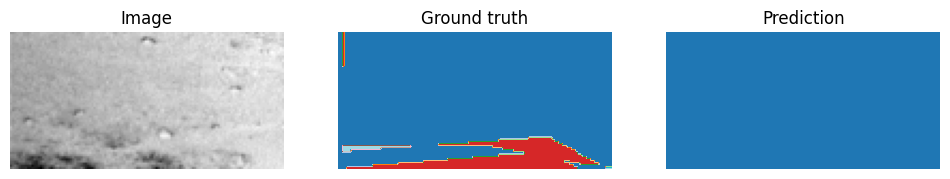

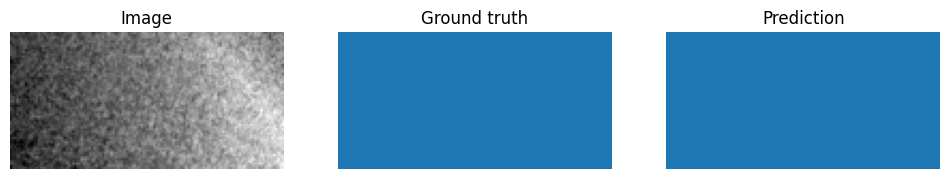

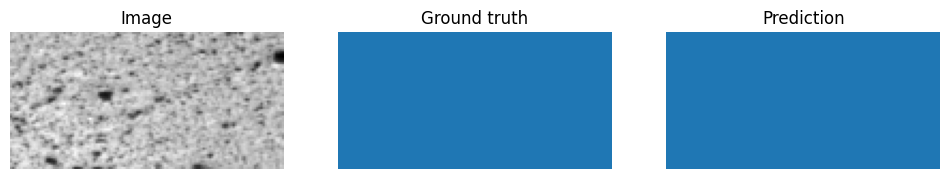

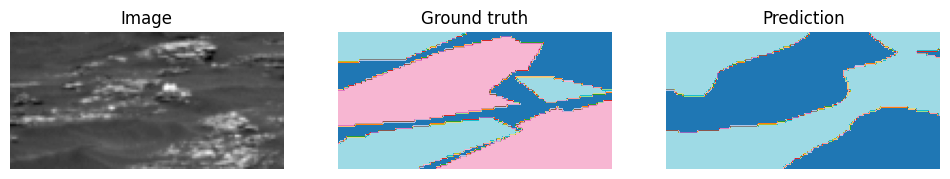

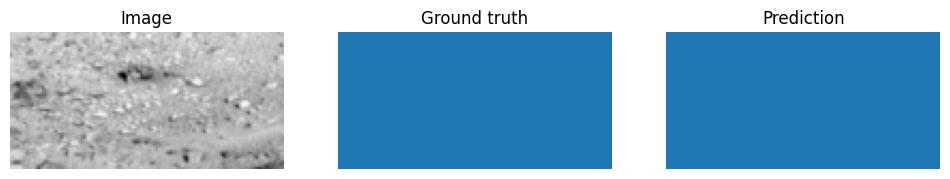

In [11]:
# Ottieni un batch dal validation loader
images, masks = next(iter(valid_loader))

# Passa il modello in modalità di valutazione
model.eval()

# Disattiva il calcolo del gradiente
with torch.no_grad():
    # Predizioni del modello (logits)
    logits = model(images)  # Shape: [batch_size, num_classes, H, W]

    # Applica softmax per ottenere le probabilità
    pr_masks = logits.softmax(dim=1)  # Shape: [batch_size, num_classes, H, W]

    # Converti le probabilità in etichette predette
    pr_masks = pr_masks.argmax(dim=1)  # Shape: [batch_size, H, W]

# Visualizza le prime 5 immagini, maschere e predizioni
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx < 5:  # Mostra solo i primi 5 campioni
        plt.figure(figsize=(12, 6))

        # Immagine originale
        plt.subplot(1, 3, 1)
        plt.imshow(
            image.squeeze(0).cpu().numpy(), cmap="gray"
        )  # Per grayscale, nessuna trasposizione necessaria
        plt.title("Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.cpu().numpy(), cmap="tab20")  # Visualizza la maschera ground truth
        plt.title("Ground truth")
        plt.axis("off")

        # Maschera Predetta
        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.cpu().numpy(), cmap="tab20")  # Visualizza la maschera predetta
        plt.title("Prediction")
        plt.axis("off")

        # Mostra la figura
        plt.show()
    else:
        break

In [12]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.pth"


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [13]:
# TensorDataset and DataLoader for X_test_tensor
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  


all_preds = [] 
model.eval()  

with torch.no_grad():
    for batch in test_loader:
        images = batch[0]  
        logits = model(images)  
        preds = logits.softmax(dim=1).argmax(dim=1)  
        all_preds.append(preds.cpu().numpy())  


all_preds = np.concatenate(all_preds, axis=0)  # Shape: [n_samples, H, W]
print(f"Predictions shape: {all_preds.shape}")

Predictions shape: (10022, 64, 128)


In [14]:

def y_to_df(y: np.ndarray) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = y.shape[0]
    y_flat = y.reshape(n_samples, -1)  
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)  
    cols = ["id"] + [col for col in df.columns if col != "id"]  
    return df[cols]

In [15]:
# Create the csv submission file
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(all_preds)
submission_df.to_csv(submission_filename, index=False)

In [16]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink(submission_filename)


/kaggle/working


/kaggle/working/submission_241214_154136.csv

In [17]:
def best_metric(checkpoint_callback, metric):
        """
        Extract the best metric value and its epoch from the ModelCheckpoint callback.
        """
        best_value = checkpoint_callback.best_model_score
        return best_value.item()  # Convert from PyTorch tensor to float



val_mean_iou = best_metric(checkpoint_callback, 'valid_mean_iou')
print(f"Best val_mean_iou: {val_mean_iou:.4f}")

Best val_mean_iou: 0.5757


#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```